# Q1

## a.

In [61]:
%matplotlib inline

from pathlib import Path
import heapq
from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pylab as plt

## you may need to install mlxtend
#import sys
#!{sys.executable} -m pip install mlxtend

from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

In [62]:
df = pd.read_csv('Coursetopics.csv')

For association rules, we considered only frequent item sets, based on the purchases of online courses. The criterion for frequency is support, i.e. the percent of purchases that include an itemset composed of courses: Intro, DataMining, Survey, Cat Data, Regression, Forecast, DOE and SW. Here, we used Apriori Algorithm to generate frequent item sets by generating all rules that meet specified minimum support.

In [ ]:
# create frequent itemsets
# Considering that frequent items are not enough, use smaller min_support to generate enough rules
itemsets = apriori(df , min_support =0.02, use_colnames =True)
itemsets

#From these item sets, we can generate rules with sufficient confidence. Noted that the minimum confidence set as 0.5.

# Rules produced by apriori
rules = association_rules(itemsets , metric='confidence', min_threshold = 0.5)
rules.sort_values(by=['lift'], ascending=False).head(10)


Considering the top 10 rules with highest lift, and its support & confidence, we come up with these best rules (antecedent -> consequent): 

(Regression, DataMining) -> Cat Data 

(Intro, DOE) -> SW 

(Regression, Cat Data) -> DataMining 

(Survey, Forecast -> Cat Data 

(Cat Data, Forecast) -> Survey 

b.

In [63]:
pip install scikit-surprise

In [64]:
from surprise import Dataset, Reader, KNNBasic
from surprise.model_selection import train_test_split

In [65]:
# find user purchased Regression and Forecast courses
pred = df[(df['Regression']==1) & (df['Forecast']==1) & (df['Intro']==0) & (df['DataMining']==0)
            & (df['Survey']==0) & (df['Cat Data']==0) & (df['DOE']==0) & (df['SW']==0)]


In [66]:
pred
# users are 21 and 80

,Intro,DataMining,Survey,Cat Data,Regression,Forecast,DOE,SW
21,0,0,0,0,1,1,0,0
80,0,0,0,0,1,1,0,0


For user-based collaborative Filtering, we created rows of triplets as userID, the course ID (name of course) and if course is purchased as its rating.

In [67]:
data_2 = df.stack()

In [68]:
data_2= data_2.reset_index()

In [69]:
data_2

,level_0,level_1,0
0,0,Intro,1
1,0,DataMining,1
2,0,Survey,0
3,0,Cat Data,0
4,0,Regression,0
...,...,...,...
2915,364,Cat Data,0
2916,364,Regression,1
2917,364,Forecast,0
2918,364,DOE,0


In [70]:
data_2 = data_2.rename(columns={data_2.columns[0]: 'userID',data_2.columns[1]:'course',data_2.columns[2]:'purchase'})

In [71]:
data_2

,userID,course,purchase
0,0,Intro,1
1,0,DataMining,1
2,0,Survey,0
3,0,Cat Data,0
4,0,Regression,0
...,...,...,...
2915,364,Cat Data,0
2916,364,Regression,1
2917,364,Forecast,0
2918,364,DOE,0


Because we used index from original dataset as the userID in new dataset, based on previous analysis, user 21 should have purchased Regression and Forecast courses.

In [72]:
test = data_2[data_2['userID']==21]

In [ ]:
test

In [73]:
data_2.head(20)

,userID,course,purchase
0,0,Intro,1
1,0,DataMining,1
2,0,Survey,0
3,0,Cat Data,0
4,0,Regression,0
5,0,Forecast,0
6,0,DOE,0
7,0,SW,0
8,1,Intro,0
9,1,DataMining,0


In [75]:
# Convert the data set into the format required by the surprise package
# Use the range from 0 to 1

reader = Reader(rating_scale =(0,1))
data =Dataset.load_from_df(data_2[['userID', 'course', 'purchase']],reader)
# Split into training and test set
trainset = data.build_full_trainset()

Use the similarity info to make recommendations

In [76]:
## User-based filtering
# compute cosine similarity between users
sim_options= {'name': 'cosine', 'user_based':True}
algo = KNNBasic(sim_options = sim_options)
algo.fit(trainset)

Computing the cosine similarity matrix...
Done computing similarity matrix.


/usr/local/lib/python3.7/dist-packages/surprise/prediction_algorithms/algo_base.py:249: RuntimeWarning: invalid value encountered in double_scalars
  sim = construction_func[name](*args)


For a new user, find other users who share his/her preferences (user 21), recommend the highest rated item that new user does not have.

In [77]:
# Assuming that userID=21 is a new user, who has purchased Regression and Forecast courses
print('Intro:', algo.predict(21,'Intro').est,
'DataMining:',algo.predict(21,'DataMining').est,
'Survey:',algo.predict(21,'Survey').est,
'Cat Data:',algo.predict(21,'Cat Data').est,
'DOE:',algo.predict(21,'DOE').est,
'SW:',algo.predict(21,'SW').est)

Intro: 0.0965082604954195 DataMining: 0.10024073045959112 Survey: 0 Cat Data: 0.07611366533573624 DOE: 0.02785953508802649 SW: 0.05198660021188137


Based on the rating, the best item with the highest rating is DataMining. Therefore, the recommendation for the new user is DataMining. All recommendations will be 1 because we created the rating from 0 to 1 based on the binary variable 'purchase?', i.e. if purchase is 1 or 0.

# Q2

In [78]:
%matplotlib inline

from pathlib import Path

import pandas as pd
from sklearn import preprocessing
from sklearn.metrics import pairwise
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.cluster import KMeans
import matplotlib.pylab as plt
import seaborn as sns
from pandas.plotting import parallel_coordinates

In [79]:
data_df = pd.read_csv('Pharmaceuticals.csv')
data_df.set_index('Symbol', inplace=True)
data_df = data_df[['Market_Cap', 'Beta', 'PE_Ratio', 'ROE', 'ROA',
       'Asset_Turnover', 'Leverage', 'Rev_Growth', 'Net_Profit_Margin']]
data_df = data_df.apply(lambda x: x.astype('float64'))

In [80]:
data_df_norm = data_df.apply(preprocessing.scale, axis=0)

In [81]:
d_norm = pairwise.pairwise_distances(data_df_norm, metric='euclidean')
pd.DataFrame(d_norm, columns=data_df_norm.index, index=data_df_norm.index).head(5)

Symbol,ABT,AGN,AHM,AZN,AVE,BAY,BMY,CHTT,ELN,LLY,GSK,IVX,JNJ,MRX,MRK,NVS,PFE,PHA,SGP,WPI,WYE
Symbol,,,,,,,,,,,,,,,,,,,,,
ABT,0.000000,4.524618,2.068648,1.710771,2.164139e+00,4.806057,1.850131,5.144714,5.022175,1.457814,3.781028,2.689547,2.391509,4.017109,2.746934,1.970213,3.983231,2.980819,1.345014,2.953797,3.113586
AGN,4.524618,0.000000,4.043186,5.030808,4.757351e+00,4.973768,5.553321,5.750821,6.860601,5.267192,6.914426,4.580415,5.449269,5.614386,5.578355,5.603897,7.077392,2.426388,4.842078,5.130736,6.605654
AHM,2.068648,4.043186,0.000000,2.422635,2.548593e+00,3.726153,2.665217,4.877898,4.811808,3.318325,5.025734,2.373755,3.682513,4.222306,3.445005,3.414021,5.398973,2.997876,1.746806,3.016647,4.288958
AZN,1.710771,5.030808,2.422635,0.000000,2.697286e+00,5.190658,1.611417,5.860410,5.097367,2.465366,3.030529,3.363249,2.006687,4.374660,1.905195,3.131669,3.186200,3.807570,1.107202,3.498439,3.407076
AVE,2.164139,4.757351,2.548593,2.697286,2.980232e-08,4.882317,3.484580,5.222098,3.841354,2.982647,4.587243,2.445794,3.730682,2.999547,3.558161,3.413135,4.606252,2.785574,2.525725,1.328568,4.359629


**Single Linkage**

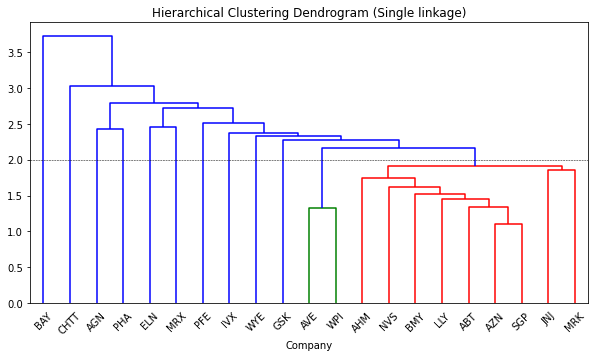

In [82]:
Z = linkage(data_df_norm, method='single')

fig = plt.figure(figsize=(10, 6))
fig.subplots_adjust(bottom=0.23)
plt.title('Hierarchical Clustering Dendrogram (Single linkage)')
plt.xlabel('Company')
dendrogram(Z, labels=data_df_norm.index, color_threshold=2)
plt.axhline(y=2, color='black', linewidth=0.5, linestyle='dashed')
plt.show()

In [83]:
## Single Linkage (Minimum distance)
memb = fcluster(linkage(data_df_norm, 'single'), 5, criterion='maxclust')
memb = pd.Series(memb, index=data_df_norm.index)
print('\033[1m'+'Single linkage cluster membership:'+'\033[0m') # prefix and suffix for 'bold' print
for key, item in memb.groupby(memb):
    print(key, ': ', ', '.join(item.index))

print('silhouette score:'+str(silhouette_score(data_df_norm,labels=memb)))

Single linkage cluster membership:
1 :  AGN, PHA
2 :  ELN, MRX
3 :  ABT, AHM, AZN, AVE, BMY, LLY, GSK, IVX, JNJ, MRK, NVS, PFE, SGP, WPI, WYE
4 :  CHTT
5 :  BAY
silhouette score:0.2708859373526622


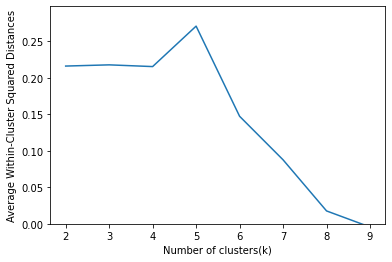

In [84]:
inertia = []
for n_clusters in range(2, 10):
  memb = fcluster(linkage(data_df_norm, 'single'), n_clusters, criterion='maxclust')
  inertia.append(silhouette_score(data_df_norm,labels=memb))
inertias = pd.DataFrame({'n_clusters': range(2, 10), 'silhouette': inertia})
ax = inertias.plot(x='n_clusters', y='silhouette')
plt.xlabel('Number of clusters(k)')
plt.ylabel('Average Within-Cluster Squared Distances')
plt.ylim((0, 1.1 * inertias.silhouette.max()))
ax.legend().set_visible(False)
plt.show()

**Average Linkage**

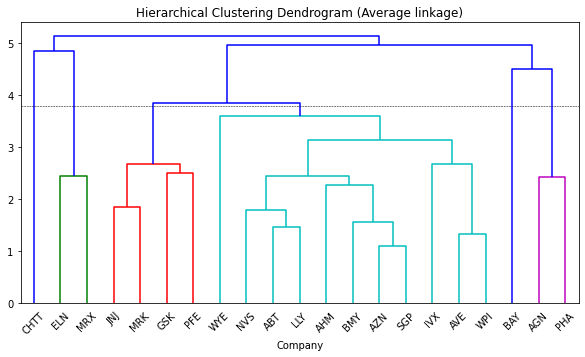

In [85]:
Z = linkage(data_df_norm, method='average')

fig = plt.figure(figsize=(10, 6))
fig.subplots_adjust(bottom=0.23)
plt.title('Hierarchical Clustering Dendrogram (Average linkage)')
plt.xlabel('Company')
dendrogram(Z, labels=data_df_norm.index, color_threshold=3.8)
plt.axhline(y=3.8, color='black', linewidth=0.5, linestyle='dashed')
plt.show()

In [86]:
memb = fcluster(linkage(data_df_norm, 'average'), 5, criterion='maxclust')
memb = pd.Series(memb, index=data_df_norm.index)
print('\033[1m'+'Average linkage cluster membership:'+'\033[0m')
for key, item in memb.groupby(memb):
    print(key, ': ', ', '.join(item.index))
  
print('silhouette score:'+str(silhouette_score(data_df_norm,labels=memb)))

Average linkage cluster membership:
1 :  ELN, MRX
2 :  CHTT
3 :  ABT, AHM, AZN, AVE, BMY, LLY, GSK, IVX, JNJ, MRK, NVS, PFE, SGP, WPI, WYE
4 :  AGN, PHA
5 :  BAY
silhouette score:0.2708859373526622


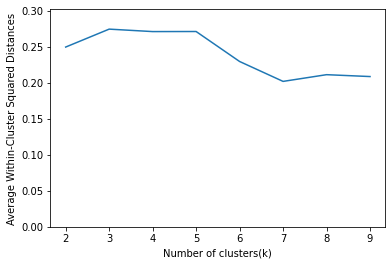

In [87]:
inertia = []
for n_clusters in range(2, 10):
  memb = fcluster(linkage(data_df_norm, 'average'), n_clusters, criterion='maxclust')
  inertia.append(silhouette_score(data_df_norm,labels=memb))
inertias = pd.DataFrame({'n_clusters': range(2, 10), 'silhouette': inertia})
ax = inertias.plot(x='n_clusters', y='silhouette')
plt.xlabel('Number of clusters(k)')
plt.ylabel('Average Within-Cluster Squared Distances')
plt.ylim((0, 1.1 * inertias.silhouette.max()))
ax.legend().set_visible(False)
plt.show()


**Complete Linkage**

In [ ]:
Z = linkage(data_df_norm, method='complete')

fig = plt.figure(figsize=(10, 6))
fig.subplots_adjust(bottom=0.23)
plt.title('Hierarchical Clustering Dendrogram (Complete linkage)')
plt.xlabel('Company')
dendrogram(Z, labels=data_df_norm.index, color_threshold=4.9)
plt.axhline(y=4.9, color='black', linewidth=0.5, linestyle='dashed')
plt.show()

In [ ]:
memb = fcluster(linkage(data_df_norm, 'complete'), 3, criterion='maxclust')
memb = pd.Series(memb, index=data_df_norm.index)
print('\033[1m'+'Complete linkage cluster membership:'+'\033[0m')
for key, item in memb.groupby(memb):
    print(key, ': ', ', '.join(item.index))
print('silhouette score:'+str(silhouette_score(data_df_norm,labels=memb)))

In [ ]:
inertia = []
for n_clusters in range(2, 10):
  memb = fcluster(linkage(data_df_norm, 'complete'), n_clusters, criterion='maxclust')
  inertia.append(silhouette_score(data_df_norm,labels=memb))
inertias = pd.DataFrame({'n_clusters': range(2, 10), 'silhouette': inertia})
ax = inertias.plot(x='n_clusters', y='silhouette')
plt.xlabel('Number of clusters(k)')
plt.ylabel('Average Within-Cluster Squared Distances')
plt.ylim((0, 1.1 * inertias.silhouette.max()))
ax.legend().set_visible(False)
plt.show()

**Centroid Distance**

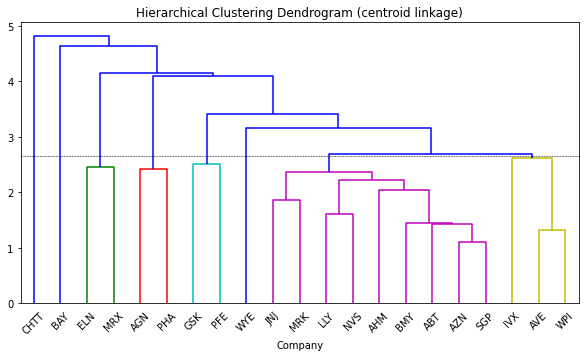

In [88]:
Z = linkage(data_df_norm, method='centroid')

fig = plt.figure(figsize=(10, 6))
fig.subplots_adjust(bottom=0.23)
plt.title('Hierarchical Clustering Dendrogram (centroid linkage)')
plt.xlabel('Company')
dendrogram(Z, labels=data_df_norm.index, color_threshold=2.65)
plt.axhline(y=2.65, color='black', linewidth=0.5, linestyle='dashed')
plt.show()


In [89]:
memb = fcluster(linkage(data_df_norm, 'complete'), 5, criterion='maxclust')
memb = pd.Series(memb, index=data_df_norm.index)
print('\033[1m'+'Complete linkage cluster membership:'+'\033[0m')
for key, item in memb.groupby(memb):
    print(key, ': ', ', '.join(item.index))

print('silhouette score:'+str(silhouette_score(data_df_norm,labels=memb)))

Complete linkage cluster membership:
1 :  ABT, AZN, BMY, LLY, GSK, JNJ, MRK, NVS, PFE, SGP, WYE
2 :  AGN, PHA
3 :  BAY
4 :  AHM, AVE, ELN, IVX, MRX, WPI
5 :  CHTT
silhouette score:0.26575036308399924


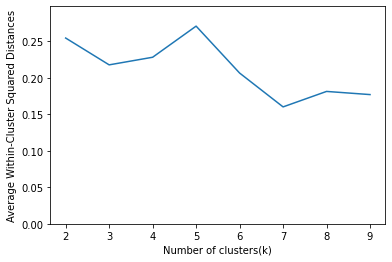

In [90]:
inertia = []
for n_clusters in range(2, 10):
  memb = fcluster(linkage(data_df_norm, 'centroid'), n_clusters, criterion='maxclust')
  inertia.append(silhouette_score(data_df_norm,labels=memb))
inertias = pd.DataFrame({'n_clusters': range(2, 10), 'silhouette': inertia})
ax = inertias.plot(x='n_clusters', y='silhouette')
plt.xlabel('Number of clusters(k)')
plt.ylabel('Average Within-Cluster Squared Distances')
plt.ylim((0, 1.1 * inertias.silhouette.max()))
ax.legend().set_visible(False)
plt.show()

**K-Means**

In [91]:
kmeans = KMeans(n_clusters=6, max_iter=300,n_init=10,random_state=42).fit(data_df_norm)
silhouette_score(data_df_norm,labels=kmeans.labels_)
# Cluster membership
memb = pd.Series(kmeans.labels_, index=data_df_norm.index)
print('\033[1m'+'k-Means cluster membership:'+'\033[0m')
for key, item in memb.groupby(memb):
    print(key, ': ', ', '.join(item.index))

  

k-Means cluster membership:
0 :  GSK, JNJ, MRK, PFE
1 :  AGN, PHA
2 :  CHTT
3 :  AVE, ELN, MRX, WPI
4 :  ABT, AZN, BMY, LLY, NVS, SGP, WYE
5 :  AHM, BAY, IVX


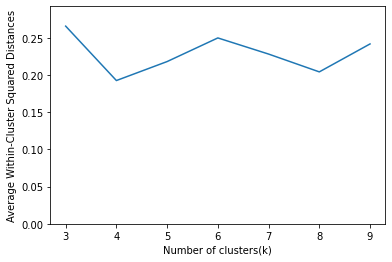

In [92]:
from sklearn.metrics import silhouette_score

inertia = []
for n_clusters in range(3, 10):
    kmeans = KMeans(n_clusters=n_clusters, max_iter=300,n_init=10,random_state=5).fit(data_df_norm)
    inertia.append(silhouette_score(data_df_norm,labels=kmeans.labels_))
inertias = pd.DataFrame({'n_clusters': range(3, 10), 'silhouette': inertia})
ax = inertias.plot(x='n_clusters', y='silhouette')
plt.xlabel('Number of clusters(k)')
plt.ylabel('Average Within-Cluster Squared Distances')
plt.ylim((0, 1.1 * inertias.silhouette.max()))
ax.legend().set_visible(False)
plt.show()


In [93]:

best_score = []
for i in range(1,200):
  inertia = []
  for n_clusters in range(4, 10):
    kmeans = KMeans(n_clusters=n_clusters, max_iter=20,n_init=10).fit(data_df_norm)
    inertia.append(silhouette_score(data_df_norm,labels=kmeans.labels_))
  best_score.append(inertia.index(max(inertia))+3)


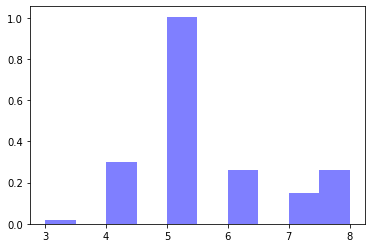

In [94]:
plt.hist(best_score, 10,
         density=True,
         histtype='bar',
         facecolor='b',
         alpha=0.5)
plt.show()

Based on the observations above we can see 3 and 5 clusters has the best Silhouette Score which is a good criteria for comparing Clusters Quality.
Also based on that, The hierarchical clustering using the average linkage is the best option because:


1.   The dataset is small so the complexity of computation is not important.
2.   It doesn’t return random results everytime.
3.   It is the one that has the highest Silhouette Score fore both clusters with size 3 and 5.



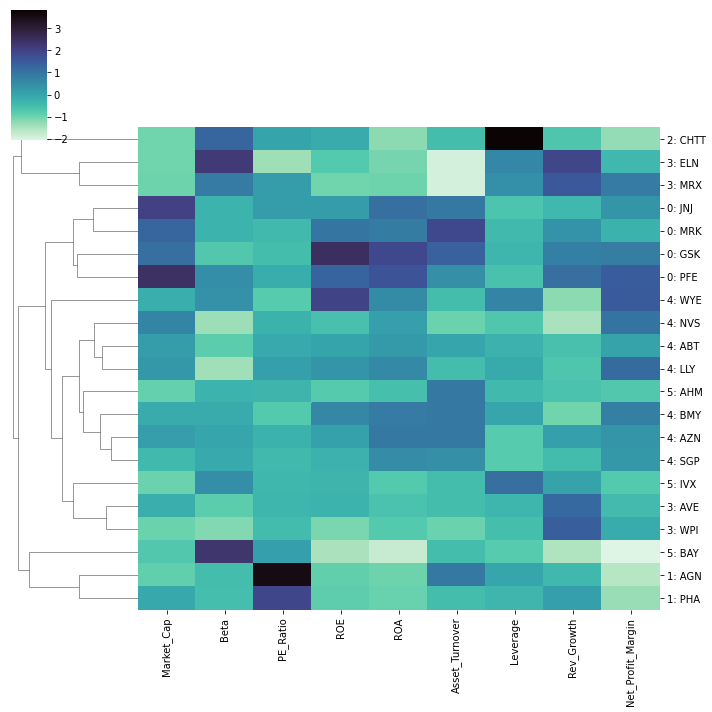

In [95]:
data_df_norm_2 = data_df_norm.copy()
data_df_norm_2.index = ['{}: {}'.format(cluster, state) for cluster, state in zip(memb, data_df_norm.index)]
sns.clustermap(data_df_norm_2, method='average', col_cluster=False,  cmap="mako_r")
plt.show()

In [96]:
memb = fcluster(linkage(data_df_norm, 'average'), 5, criterion='maxclust')
memb = pd.Series(memb, index=data_df_norm.index)
print('\033[1m'+'Average linkage cluster membership:'+'\033[0m')
for key, item in memb.groupby(memb):
    print(key, ': ', ', '.join(item.index))
  
print('silhouette score:'+str(silhouette_score(data_df_norm,labels=memb)))

Average linkage cluster membership:
1 :  ELN, MRX
2 :  CHTT
3 :  ABT, AHM, AZN, AVE, BMY, LLY, GSK, IVX, JNJ, MRK, NVS, PFE, SGP, WPI, WYE
4 :  AGN, PHA
5 :  BAY
silhouette score:0.2708859373526622


In [97]:
memb = fcluster(linkage(data_df_norm, 'average'), 3, criterion='maxclust')
data_complete_df = pd.read_csv('Pharmaceuticals.csv')
data_complete_df.set_index('Symbol', inplace=True)
data_complete_df['Group'] = memb
data_complete_df

,Name,Market_Cap,Beta,PE_Ratio,ROE,ROA,Asset_Turnover,Leverage,Rev_Growth,Net_Profit_Margin,Median_Recommendation,Location,Exchange,Group
Symbol,,,,,,,,,,,,,,
ABT,Abbott Laboratories,68.44,0.32,24.7,26.4,11.8,0.7,0.42,7.54,16.1,Moderate Buy,US,NYSE,2
AGN,"Allergan, Inc.",7.58,0.41,82.5,12.9,5.5,0.9,0.60,9.16,5.5,Moderate Buy,CANADA,NYSE,3
AHM,Amersham plc,6.30,0.46,20.7,14.9,7.8,0.9,0.27,7.05,11.2,Strong Buy,UK,NYSE,2
AZN,AstraZeneca PLC,67.63,0.52,21.5,27.4,15.4,0.9,0.00,15.00,18.0,Moderate Sell,UK,NYSE,2
AVE,Aventis,47.16,0.32,20.1,21.8,7.5,0.6,0.34,26.81,12.9,Moderate Buy,FRANCE,NYSE,2
BAY,Bayer AG,16.90,1.11,27.9,3.9,1.4,0.6,0.00,-3.17,2.6,Hold,GERMANY,NYSE,3
BMY,Bristol-Myers Squibb Company,51.33,0.50,13.9,34.8,15.1,0.9,0.57,2.70,20.6,Moderate Sell,US,NYSE,2
CHTT,"Chattem, Inc",0.41,0.85,26.0,24.1,4.3,0.6,3.51,6.38,7.5,Moderate Buy,US,NASDAQ,1
ELN,"Elan Corporation, plc",0.78,1.08,3.6,15.1,5.1,0.3,1.07,34.21,13.3,Moderate Sell,IRELAND,NYSE,1


In [98]:
cat_data = data_complete_df[['Median_Recommendation','Location','Exchange','Group']]
cat_data = cat_data.astype('category')
cat_data.dtypes

Median_Recommendation    category
Location                 category
Exchange                 category
Group                    category
dtype: object

In [99]:
cat_data = pd.get_dummies(cat_data, columns=['Median_Recommendation','Location','Exchange','Group'])

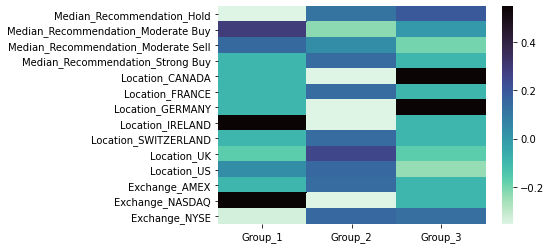

In [100]:
new_cat_data = cat_data.corr()
new_cat_data = new_cat_data[[x for x in new_cat_data.columns if 'Group' in x]]
new_cat_data = new_cat_data[~new_cat_data.index.str.contains('Group')]
sns.heatmap(new_cat_data,  cmap="mako_r")

The Group Column is correlated to Location and Median Recommendation

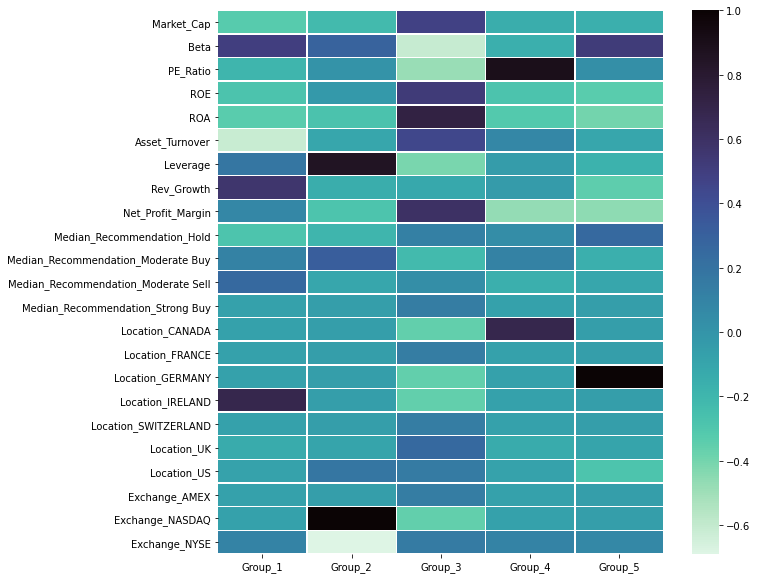

In [101]:
memb = fcluster(linkage(data_df_norm, 'average'), 5, criterion='maxclust')
data_complete_df = pd.read_csv('Pharmaceuticals.csv')
data_complete_df.set_index('Symbol', inplace=True)
data_complete_df['Group'] = memb

data_complete_df[['Median_Recommendation','Location','Exchange','Group']] = data_complete_df[['Median_Recommendation','Location','Exchange','Group']].astype('category')
data_complete_dum_df = pd.get_dummies(data_complete_df, columns=['Median_Recommendation','Location','Exchange','Group'])
new_cat_data = data_complete_dum_df.corr()
new_cat_data = new_cat_data[[x for x in new_cat_data.columns if 'Group' in x]]
new_cat_data = new_cat_data[~new_cat_data.index.str.contains('Group')]
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(new_cat_data, linewidths=.5, ax=ax,  cmap="mako_r")


Based on above heatmap , we can name our group based on net profit margin

In [102]:
data_complete_df[data_complete_df.Group == 1].mean()

Market_Cap            0.990
Beta                  0.915
PE_Ratio             16.100
ROE                  13.150
ROA                   5.250
Asset_Turnover        0.300
Leverage              1.000
Rev_Growth           32.290
Net_Profit_Margin    17.300
dtype: float64

In [103]:
data_complete_df[data_complete_df.Group == 2].mean()

Market_Cap            0.41
Beta                  0.85
PE_Ratio             26.00
ROE                  24.10
ROA                   4.30
Asset_Turnover        0.60
Leverage              3.51
Rev_Growth            6.38
Net_Profit_Margin     7.50
dtype: float64

In [104]:
data_complete_df[data_complete_df.Group == 3].mean()

Market_Cap           75.171333
Beta                  0.429333
PE_Ratio             20.640000
ROE                  30.733333
ROA                  12.893333
Asset_Turnover        0.760000
Leverage              0.389333
Rev_Growth           12.589333
Net_Profit_Margin    18.140000
dtype: float64

for k = 3
Beta, Net Profit Margin, PE Ratio, Market Cap

for k = 5
Beta, Asset turnover

# Q3

## a.

In [105]:
from pathlib import Path
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.metrics import pairwise
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.cluster import KMeans
import matplotlib.pylab as plt
import seaborn as sns
from pandas.plotting import parallel_coordinates

In [ ]:
cereals_df = pd.read_csv('Cereals.csv')
cereals_df=cereals_df.dropna()
cereals_df=cereals_df.drop(columns=['mfr', 'type'])
print(cereals_df.head())
cereals_df.set_index('name', inplace=True)
print (cereals_df.dtypes)

                        name  calories  protein  ...  weight  cups     rating
0                  100%_Bran        70        4  ...     1.0  0.33  68.402973
1          100%_Natural_Bran       120        3  ...     1.0  1.00  33.983679
2                   All-Bran        70        4  ...     1.0  0.33  59.425505
3  All-Bran_with_Extra_Fiber        50        4  ...     1.0  0.50  93.704912
5    Apple_Cinnamon_Cheerios       110        2  ...     1.0  0.75  29.509541

[5 rows x 14 columns]
calories      int64
protein       int64
fat           int64
sodium        int64
fiber       float64
carbo       float64
sugars      float64
potass      float64
vitamins      int64
shelf         int64
weight      float64
cups        float64
rating      float64
dtype: object


In [ ]:
cereals_df['calories'] = cereals_df['calories'].astype(float)
cereals_df['protein'] = cereals_df['protein'].astype(float)
cereals_df['fat'] = cereals_df['fat'].astype(float)
cereals_df['sodium'] = cereals_df['sodium'].astype(float)
cereals_df['vitamins'] = cereals_df['vitamins'].astype(float)
cereals_df['shelf'] = cereals_df['shelf'].astype(float)



print(cereals_df.dtypes)
#changing all datatypes to float

calories    float64
protein     float64
fat         float64
sodium      float64
fiber       float64
carbo       float64
sugars      float64
potass      float64
vitamins    float64
shelf       float64
weight      float64
cups        float64
rating      float64
dtype: object


In [ ]:
cereals_df.head()

,calories,protein,fat,sodium,fiber,carbo,sugars,potass,vitamins,shelf,weight,cups,rating
name,,,,,,,,,,,,,
100%_Bran,70.0,4.0,1.0,130.0,10.0,5.0,6.0,280.0,25.0,3.0,1.0,0.33,68.402973
100%_Natural_Bran,120.0,3.0,5.0,15.0,2.0,8.0,8.0,135.0,0.0,3.0,1.0,1.00,33.983679
All-Bran,70.0,4.0,1.0,260.0,9.0,7.0,5.0,320.0,25.0,3.0,1.0,0.33,59.425505
All-Bran_with_Extra_Fiber,50.0,4.0,0.0,140.0,14.0,8.0,0.0,330.0,25.0,3.0,1.0,0.50,93.704912
Apple_Cinnamon_Cheerios,110.0,2.0,2.0,180.0,1.5,10.5,10.0,70.0,25.0,1.0,1.0,0.75,29.509541


In [ ]:
d = pairwise.pairwise_distances(cereals_df, metric='euclidean')
pd.DataFrame(d, columns=cereals_df.index, index=cereals_df.index).head(5)

name,100%_Bran,100%_Natural_Bran,All-Bran,All-Bran_with_Extra_Fiber,Apple_Cinnamon_Cheerios,Apple_Jacks,Basic_4,Bran_Chex,Bran_Flakes,Cap'n'Crunch,Cheerios,Cinnamon_Toast_Crunch,Clusters,Cocoa_Puffs,Corn_Chex,Corn_Flakes,Corn_Pops,Count_Chocula,Cracklin'_Oat_Bran,Crispix,Crispy_Wheat_&_Raisins,Double_Chex,Froot_Loops,Frosted_Flakes,Frosted_Mini-Wheats,"Fruit_&_Fibre_Dates,_Walnuts,_and_Oats",Fruitful_Bran,Fruity_Pebbles,Golden_Crisp,Golden_Grahams,Grape_Nuts_Flakes,Grape-Nuts,Great_Grains_Pecan,Honey_Graham_Ohs,Honey_Nut_Cheerios,Honey-comb,Just_Right_Crunchy__Nuggets,Just_Right_Fruit_&_Nut,Kix,Life,Lucky_Charms,Maypo,"Muesli_Raisins,_Dates,_&_Almonds","Muesli_Raisins,_Peaches,_&_Pecans",Mueslix_Crispy_Blend,Multi-Grain_Cheerios,Nut&Honey_Crunch,Nutri-Grain_Almond-Raisin,Nutri-grain_Wheat,Oatmeal_Raisin_Crisp,Post_Nat._Raisin_Bran,Product_19,Puffed_Rice,Puffed_Wheat,Quaker_Oat_Squares,Raisin_Bran,Raisin_Nut_Bran,Raisin_Squares,Rice_Chex,Rice_Krispies,Shredded_Wheat,Shredded_Wheat_'n'Bran,Shredded_Wheat_spoon_size,Smacks,Special_K,Strawberry_Fruit_Wheats,Total_Corn_Flakes,Total_Raisin_Bran,Total_Whole_Grain,Triples,Trix,Wheat_Chex,Wheaties,Wheaties_Honey_Gold
name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100%_Bran,0.000000,196.606553,136.332663,60.845846,223.249581,256.034222,208.861226,172.745301,123.368547,270.845562,241.617351,258.209478,182.318907,238.786265,300.431656,295.627273,268.433465,229.455972,130.186275,270.211055,166.609548,212.921683,256.137766,270.356682,224.578229,103.187471,153.604357,261.706888,258.940650,285.540262,198.602224,199.323773,196.360294,261.068279,231.579925,256.746879,241.807233,218.332051,278.067947,190.190869,238.016195,228.998050,144.575304,142.384748,156.828521,214.646616,255.723923,191.248803,195.992829,180.008210,94.081260,314.469440,297.353617,266.461686,174.146210,107.208418,146.683995,215.730965,278.121940,297.334275,228.178671,194.514679,209.428902,253.702586,250.357089,223.524388,270.912224,135.689167,202.430867,256.178607,261.892812,196.668893,187.590115,236.964152
100%_Natural_Bran,196.606553,0.000000,313.207176,250.949947,179.498135,154.672737,200.233623,190.150532,207.404829,230.117736,278.717913,216.770780,131.629867,185.856128,288.722482,295.003603,140.179302,181.797311,130.499224,232.728853,130.037955,186.863925,154.616152,217.107239,55.968927,161.124930,233.260936,165.307469,105.088649,281.475909,139.829821,165.176969,75.075638,225.691626,240.873492,195.088646,199.648320,190.242850,264.610829,144.947591,185.624757,58.278998,96.119418,145.100049,145.618784,212.571123,200.906913,208.087058,168.509324,158.212811,224.871282,334.329999,142.702534,115.271525,127.860763,223.116567,129.319238,53.944875,250.474073,294.360748,68.972766,54.840586,55.632314,113.365096,232.044462,65.422934,233.588487,224.018552,213.346338,248.628845,168.981708,219.150332,190.557235,201.657927
All-Bran,136.332663,313.207176,0.000000,126.992546,267.390429,323.699839,234.909473,205.497722,141.037117,295.302727,221.302623,286.950326,250.355729,282.403144,299.445733,288.941831,348.165804,273.087157,204.946689,296.186506,236.505194,252.622297,323.751856,305.240217,342.042962,165.259617,142.320600,324.672327,355.409115,281.185108,265.857677,250.556707,292.212825,285.082037,235.606845,300.578529,289.169401,264.598096,284.068264,252.786181,281.876125,345.417683,238.283932,204.442700,216.448338,236.422701,294.680229,207.820010,248.129998,229.488829,101.356464,293.786735,402.249263,376.352915,246.621793,109.192332,219.441314,335.016084,294.557847,290.517384,345.223262,318.514585,330.212114,342.152247,270.042711,336.795862,304.563987,156.994763,233.474702,264.571449,322.807338,209.911905,220.922633,271.112852
All-Bran_with_Extra_Fiber,60.845846,250.949947,126.992546,0.000000,277.840976,312.838984,260.238826,222.276451,166.923545,323.140542,280.726555,311.134239,239.352024,293.689927,345.492904,338.620832,325.427753,284.433011,188.412357,320.222356,223.981284,265.020490,312.985897,323.17

In [ ]:
print(cereals_df.dtypes)

calories    float64
protein     float64
fat         float64
sodium      float64
fiber       float64
carbo       float64
sugars      float64
potass      float64
vitamins    float64
shelf       float64
weight      float64
cups        float64
rating      float64
dtype: object


In [ ]:
# scikit-learn uses population standard deviation
cereals_df_norm = cereals_df.apply(preprocessing.scale, axis=0)

# pandas uses sample standard deviation
cereals_df_norm = (cereals_df - cereals_df.mean())/cereals_df.std()

# compute normalized distance based on Sodium and Potassium
d_norm = pairwise.pairwise_distances(cereals_df_norm[['calories','protein','sodium','fiber','carbo','sugars','vitamins','shelf','weight','cups','rating','potass']], metric='euclidean')
pd.DataFrame(d_norm, columns=cereals_df.index, index=cereals_df.index).head(5)

name,100%_Bran,100%_Natural_Bran,All-Bran,All-Bran_with_Extra_Fiber,Apple_Cinnamon_Cheerios,Apple_Jacks,Basic_4,Bran_Chex,Bran_Flakes,Cap'n'Crunch,Cheerios,Cinnamon_Toast_Crunch,Clusters,Cocoa_Puffs,Corn_Chex,Corn_Flakes,Corn_Pops,Count_Chocula,Cracklin'_Oat_Bran,Crispix,Crispy_Wheat_&_Raisins,Double_Chex,Froot_Loops,Frosted_Flakes,Frosted_Mini-Wheats,"Fruit_&_Fibre_Dates,_Walnuts,_and_Oats",Fruitful_Bran,Fruity_Pebbles,Golden_Crisp,Golden_Grahams,Grape_Nuts_Flakes,Grape-Nuts,Great_Grains_Pecan,Honey_Graham_Ohs,Honey_Nut_Cheerios,Honey-comb,Just_Right_Crunchy__Nuggets,Just_Right_Fruit_&_Nut,Kix,Life,Lucky_Charms,Maypo,"Muesli_Raisins,_Dates,_&_Almonds","Muesli_Raisins,_Peaches,_&_Pecans",Mueslix_Crispy_Blend,Multi-Grain_Cheerios,Nut&Honey_Crunch,Nutri-Grain_Almond-Raisin,Nutri-grain_Wheat,Oatmeal_Raisin_Crisp,Post_Nat._Raisin_Bran,Product_19,Puffed_Rice,Puffed_Wheat,Quaker_Oat_Squares,Raisin_Bran,Raisin_Nut_Bran,Raisin_Squares,Rice_Chex,Rice_Krispies,Shredded_Wheat,Shredded_Wheat_'n'Bran,Shredded_Wheat_spoon_size,Smacks,Special_K,Strawberry_Fruit_Wheats,Total_Corn_Flakes,Total_Raisin_Bran,Total_Whole_Grain,Triples,Trix,Wheat_Chex,Wheaties,Wheaties_Honey_Gold
name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100%_Bran,0.000000,6.354743,1.918743,3.242218,6.959706e+00,7.438183,7.242461,5.696335,4.024712,8.179838,7.852650,8.023781,5.542167,8.076867,8.824804,8.330699,7.769709,8.032321,4.486577,7.920834,5.780741,6.734249,7.408622,7.864201,5.634176,5.052165,5.710255,7.799476,7.663619,8.058497,5.703496,5.651040,5.429074,8.072244,6.795402,8.922246,8.077377,8.371031,9.287404,5.433050,7.645815,6.892880,7.037868,7.099886,8.053443,7.037958,7.546036,7.407715,6.173524,6.613593,5.284632,8.461933,8.284986,7.410321,5.159449,5.789986,4.853229,5.619553,9.281455,8.807986,6.896327,6.206183,6.614422,7.089242,7.506829,6.206905,8.855571,8.276283,6.944136,7.822578,8.115376,6.162087,6.575286,7.354116
100%_Natural_Bran,6.354743,0.000000,6.655346,8.655159,3.854895e+00,3.231563,4.439323,4.738198,4.148444,4.390618,6.063415,4.224707,3.222292,3.918595,6.002748,5.990347,3.541882,3.885385,3.102599,4.918887,2.723391,4.138221,3.142737,4.725266,3.213653,3.581395,4.564936,3.924457,3.868339,4.888250,3.294280,4.928277,3.671435,4.043502,4.240626,4.726608,5.623656,6.284993,5.672151,3.382426,3.451685,3.656026,3.241179,3.490122,5.252595,4.369026,3.980620,5.158440,4.411754,3.812062,4.608580,6.899783,6.225757,5.786156,3.697967,4.592537,3.111241,3.850195,6.196093,6.028277,5.099529,5.515750,5.549609,3.167997,5.537141,3.661221,6.441944,6.631904,5.725609,5.096052,3.804229,4.994006,4.645371,4.451291
All-Bran,1.918743,6.655346,0.000000,3.906774,6.789219e+00,7.493973,6.867189,5.431306,3.602832,7.865313,7.350657,7.690072,5.433179,7.869048,8.322130,7.819506,7.885942,7.811151,4.419867,7.577555,5.695683,6.414140,7.451670,7.658030,6.136206,4.868778,5.253762,7.734104,7.899063,7.541457,5.684938,5.466626,5.598507,7.780720,6.382534,8.741849,7.859404,8.118019,8.844202,5.358143,7.443377,7.156190,6.977096,6.869941,7.835971,6.699187,7.275308,6.964060,6.022006,6.346053,4.937575,7.875439,8.638815,7.853765,5.098548,5.357346,4.761573,6.028658,8.868239,8.266914,7.292787,6.598664,6.952533,7.312644,7.221055,6.606284,8.526740,7.951463,6.660774,7.294209,8.039233,5.737521,6.290066,7.065030
All-Bran_with_Extra_Fiber,3.242218,8.655159,3.906774,0.000000,9.294947e+00,9.735479,9.214591,7.413390,5.925072,10.588785,9.007989,10.328387,7.953596,10.346351,10.242543,9.615416,9.868988,10.306195,7.073208,9.353140,8.178574,8.532796,9.693167,10.003629,7.454894,7.359747,7.852352,10.124952,9.969793,10.207773,7.464120,7.577167,7.727683,10.279467,9.095926,10.779510,9.781548,10.185607,10.533328,7.659919,9.930301,8.478502,9.095635,9.176977,10.185810,8.758896,9.823288,9.169932,7.370978,9.102919,7.590010,9.824523,9.343676,8.492807,7.395566,7.850503,7.450188,7.559119,10.546547,10.228013,7.776926,7.030228,7.513423,9.650131,8.996993,7.638834,10.322487,10.115941,8.350453,9.494371,10.298919,7.753230,7

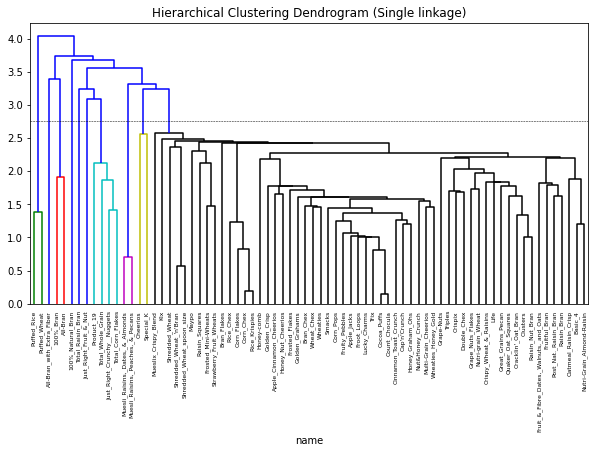

In [ ]:
#single linkage hierachal clustering
Z = linkage(cereals_df_norm, method='single')

fig = plt.figure(figsize=(10, 6))
fig.subplots_adjust(bottom=0.23)
plt.title('Hierarchical Clustering Dendrogram (Single linkage)')
plt.xlabel('name')
dendrogram(Z, labels=cereals_df_norm.index, color_threshold=2.75)
plt.axhline(y=2.75, color='black', linewidth=0.5, linestyle='dashed')
plt.show()

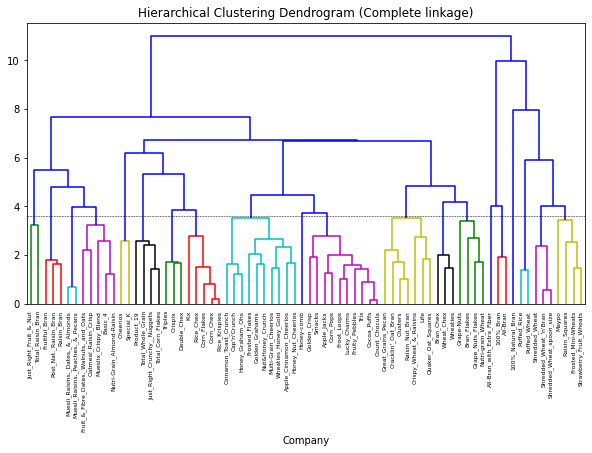

In [ ]:
#complete linkage hierachal clustering
Z = linkage(cereals_df_norm, method='complete')
fig = plt.figure(figsize=(10, 6))
fig.subplots_adjust(bottom=0.23)
plt.title('Hierarchical Clustering Dendrogram (Complete linkage)')
plt.xlabel('Company')
dendrogram(Z, labels=cereals_df_norm.index, color_threshold=3.6)
plt.axhline(y=3.6, color='black', linewidth=0.5, linestyle='dashed')
plt.show()

In [ ]:
## Single Linkage (Minimum distance)
memb = fcluster(linkage(cereals_df_norm, 'single'), 6, criterion='maxclust')
memb = pd.Series(memb, index=cereals_df_norm.index)
print('\033[1m'+'Single linkage cluster membership:'+'\033[0m') # prefix and suffix for 'bold' print
for key, item in memb.groupby(memb):
  #clusteritem=[]
  #clusteritem.append(item.index)
  #dfclusteritem=pd.DataFrame(clusteritem,columns=cereals_df_norm.columns)
  #print(dfclusteritem)
  print(key, ': ', ', '.join(item.index))
   

Single linkage cluster membership:
1 :  Puffed_Rice, Puffed_Wheat
2 :  100%_Bran, All-Bran
3 :  All-Bran_with_Extra_Fiber
4 :  Just_Right_Crunchy__Nuggets, Just_Right_Fruit_&_Nut, Product_19, Total_Corn_Flakes, Total_Raisin_Bran, Total_Whole_Grain
5 :  Apple_Cinnamon_Cheerios, Apple_Jacks, Basic_4, Bran_Chex, Bran_Flakes, Cap'n'Crunch, Cheerios, Cinnamon_Toast_Crunch, Clusters, Cocoa_Puffs, Corn_Chex, Corn_Flakes, Corn_Pops, Count_Chocula, Cracklin'_Oat_Bran, Crispix, Crispy_Wheat_&_Raisins, Double_Chex, Froot_Loops, Frosted_Flakes, Frosted_Mini-Wheats, Fruit_&_Fibre_Dates,_Walnuts,_and_Oats, Fruitful_Bran, Fruity_Pebbles, Golden_Crisp, Golden_Grahams, Grape_Nuts_Flakes, Grape-Nuts, Great_Grains_Pecan, Honey_Graham_Ohs, Honey_Nut_Cheerios, Honey-comb, Kix, Life, Lucky_Charms, Maypo, Muesli_Raisins,_Dates,_&_Almonds, Muesli_Raisins,_Peaches,_&_Pecans, Mueslix_Crispy_Blend, Multi-Grain_Cheerios, Nut&Honey_Crunch, Nutri-Grain_Almond-Raisin, Nutri-grain_Wheat, Oatmeal_Raisin_Crisp, Post_Na

In [ ]:
#single linkage
memb_df=pd.DataFrame(memb)
memb_df=memb_df.rename(columns={0:'label'})
memb_norm=pd.concat([cereals_df_norm,memb_df],axis=1)
centroids=memb_norm.groupby(['label']).mean()
centroids

,calories,protein,fat,sodium,fiber,carbo,sugars,potass,vitamins,shelf,weight,cups,rating
label,,,,,,,,,,,,,
1,-2.873782,-0.942101,-9.932203e-01,-1.961644,-0.691459,-0.829907,-1.630632,-0.931359,-1.303202,0.941971,-3.459955,0.756753,1.390159
2,-1.865915,1.381748,0.000000e+00,0.394288,3.022345,-2.243181,-0.368907,2.842695,-0.181842,0.941971,-0.200832,-2.085658,1.535050
3,-2.873782,1.381748,-9.932203e-01,-0.270206,4.879247,-1.729263,-1.630632,3.265954,-0.181842,0.941971,-0.200832,-1.364449,3.657844
4,0.485774,0.142362,-1.655367e-01,0.555377,-0.141266,0.883151,-0.177737,-0.037814,3.182239,0.941971,0.668267,0.579987,-0.304512
5,0.141690,-0.057539,3.581365e-18,0.029888,-0.139047,0.069448,0.104702,-0.118976,-0.236102,-0.182317,0.059897,-0.003458,-0.114250
6,0.653751,0.452208,3.972881e+00,-1.780419,-0.072492,-1.729263,0.204604,0.514774,-1.303202,0.941971,-0.200832,0.756753,-0.597711


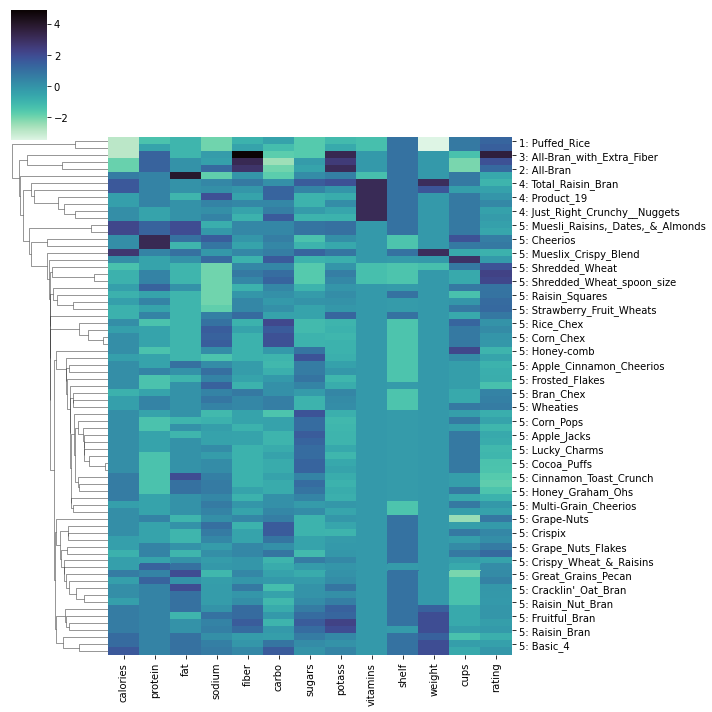

In [ ]:
cereals_df_norm.index = ['{}: {}'.format(cluster, state) for cluster, state in zip(memb, cereals_df_norm.index)]
sns.clustermap(cereals_df_norm, method='single', col_cluster=False,  cmap="mako_r")
plt.show()

In [ ]:
# Complete Linkage (Maximum distance)
memb = fcluster(linkage(cereals_df_norm, 'complete'), 6, criterion='maxclust')
memb = pd.Series(memb, index=cereals_df_norm.index)
print('\033[1m'+'Complete linkage cluster membership:'+'\033[0m')
for key, item in memb.groupby(memb):
    print(key, ': ', ', '.join(item.index))

Complete linkage cluster membership:
1 :  5: Basic_4, 5: Fruit_&_Fibre_Dates,_Walnuts,_and_Oats, 5: Fruitful_Bran, 4: Just_Right_Fruit_&_Nut, 5: Muesli_Raisins,_Dates,_&_Almonds, 5: Muesli_Raisins,_Peaches,_&_Pecans, 5: Mueslix_Crispy_Blend, 5: Nutri-Grain_Almond-Raisin, 5: Oatmeal_Raisin_Crisp, 5: Post_Nat._Raisin_Bran, 5: Raisin_Bran, 4: Total_Raisin_Bran
2 :  5: Cheerios, 5: Corn_Chex, 5: Corn_Flakes, 5: Crispix, 5: Double_Chex, 4: Just_Right_Crunchy__Nuggets, 5: Kix, 4: Product_19, 5: Rice_Chex, 5: Rice_Krispies, 5: Special_K, 4: Total_Corn_Flakes, 4: Total_Whole_Grain, 5: Triples
3 :  5: Apple_Cinnamon_Cheerios, 5: Apple_Jacks, 5: Bran_Chex, 5: Bran_Flakes, 5: Cap'n'Crunch, 5: Cinnamon_Toast_Crunch, 5: Clusters, 5: Cocoa_Puffs, 5: Corn_Pops, 5: Count_Chocula, 5: Cracklin'_Oat_Bran, 5: Crispy_Wheat_&_Raisins, 5: Froot_Loops, 5: Frosted_Flakes, 5: Fruity_Pebbles, 5: Golden_Crisp, 5: Golden_Grahams, 5: Grape_Nuts_Flakes, 5: Grape-Nuts, 5: Great_Grains_Pecan, 5: Honey_Graham_Ohs, 5: H

In [ ]:
#Complete linkage
memb_df=pd.DataFrame(memb)
memb_df=memb_df.rename(columns={0:'label'})
memb_norm=pd.concat([cereals_df_norm,memb_df],axis=1)
centroids=memb_norm.groupby(['label']).mean()
centroids


,calories,protein,fat,sodium,fiber,carbo,sugars,potass,vitamins,shelf,weight,cups,rating
label,,,,,,,,,,,,,
1,1.409651,0.607132,0.662147,0.218097,0.563669,0.230048,0.873701,1.037968,0.378838,0.841819,1.673163,-0.268495,-0.442940
2,0.005837,0.120230,-0.496610,0.998373,-0.573560,1.280825,-0.926033,-0.639109,0.779324,-0.174010,-0.200832,0.871904,0.069518
3,0.005837,-0.371098,0.113511,0.061178,-0.267024,-0.404090,0.414345,-0.341821,-0.181842,-0.259854,-0.200832,-0.149909,-0.429404
4,-2.201871,1.381748,-0.331073,0.172790,3.641312,-2.071875,-0.789482,2.983781,-0.181842,0.941971,-0.200832,-1.845255,2.242648
5,-1.249997,-0.064202,-0.882862,-1.941508,-0.026642,0.155101,-1.095355,-0.112276,-0.804820,-0.259854,-1.048204,0.115679,1.471215
6,0.653751,0.452208,3.972881,-1.780419,-0.072492,-1.729263,0.204604,0.514774,-1.303202,0.941971,-0.200832,0.756753,-0.597711


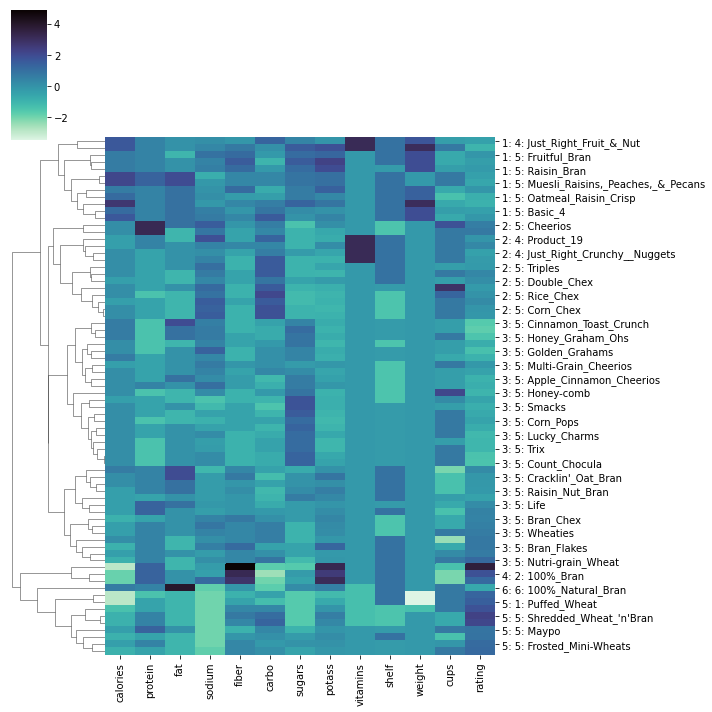

In [ ]:
cereals_df_norm.index = ['{}: {}'.format(cluster, state) for cluster, state in zip(memb, cereals_df_norm.index)]
sns.clustermap(cereals_df_norm, method='complete', col_cluster=False,  cmap="mako_r")
plt.show()

(-0.5, 7.5)

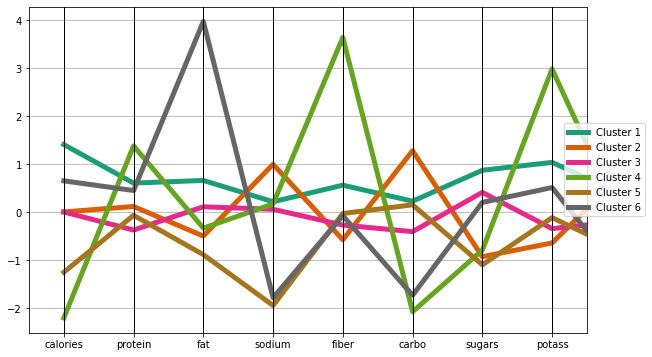

In [ ]:
centroids['cluster'] = ['Cluster {}'.format(i) for i in centroids.index]

plt.figure(figsize=(10,6))
fig.subplots_adjust(right=3)
ax = parallel_coordinates(centroids, class_column='cluster', colormap='Dark2', linewidth=5)
plt.legend(loc='center left', bbox_to_anchor=(0.95, 0.5))
plt.xlim(-0.5,7.5)

In [ ]:
#a) OBSERVATIONS
#complete linkage is better for stability because there are more cereals in each cluster and the cereals wont change much between clusters by changing measurements
#single linkage first few clusters have only 2 cereals but for complete linkage there are more cereals in each cluster
# 100% natural bran is always its own cluster in both single and complete linkage
#all bran, all bran with extra fibre, and 100% natural bran are all grouped into one cluster in complete linkage whereas in single linkage, 100% natural bran is seperate from the two
#b) most meaningful clusters is single linkage because the mean centroids show large differences between the cluster with the highest average and the rest of the values whereas the values in complete linkage are very similiar to each other which makes differentiation difficult to observe.
#c) for the single linkage there are 6 clusters and distance is 2.75
#d) the healthiest cluster is cluster 4 as it is the highest in vitamins, the data should be normalized because Euclidean distance is very sensitive to the changes in the differences and normalizing is essntial to do before clustering

# Q4


## a.

In [109]:
%matplotlib inline
% pip install dmba
from pathlib import Path
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from math import sqrt
from dmba import classificationSummary
import pydotplus
from IPython.display import Image
import numbers
from matplotlib import pyplot as plt
example_df = pd.read_csv('ToyotaCorolla.csv')

In [110]:
example_df = pd.get_dummies(example_df, columns=["Fuel_Type"])
example_df.head(5)

,Id,Model,Price,Age_08_04,Mfg_Month,Mfg_Year,KM,HP,Met_Color,Color,Automatic,CC,Doors,Cylinders,Gears,Quarterly_Tax,Weight,Mfr_Guarantee,BOVAG_Guarantee,Guarantee_Period,ABS,Airbag_1,Airbag_2,Airco,Automatic_airco,Boardcomputer,CD_Player,Central_Lock,Powered_Windows,Power_Steering,Radio,Mistlamps,Sport_Model,Backseat_Divider,Metallic_Rim,Radio_cassette,Parking_Assistant,Tow_Bar,Fuel_Type_CNG,Fuel_Type_Diesel,Fuel_Type_Petrol
0,1,TOYOTA Corolla 2.0 D4D HATCHB TERRA 2/3-Doors,13500,23,10,2002,46986,90,1,Blue,0,2000,3,4,5,210,1165,0,1,3,1,1,1,0,0,1,0,1,1,1,0,0,0,1,0,0,0,0,0,1,0
1,2,TOYOTA Corolla 2.0 D4D HATCHB TERRA 2/3-Doors,13750,23,10,2002,72937,90,1,Silver,0,2000,3,4,5,210,1165,0,1,3,1,1,1,1,0,1,1,1,0,1,0,0,0,1,0,0,0,0,0,1,0
2,3,TOYOTA Corolla 2.0 D4D HATCHB TERRA 2/3-Doors,13950,24,9,2002,41711,90,1,Blue,0,2000,3,4,5,210,1165,1,1,3,1,1,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0
3,4,TOYOTA Corolla 2.0 D4D HATCHB TERRA 2/3-Doors,14950,26,7,2002,48000,90,0,Black,0,2000,3,4,5,210,1165,1,1,3,1,1,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0
4,5,TOYOTA Corolla 2.0 D4D HATCHB SOL 2/3-Doors,13750,30,3,2002,38500,90,0,Black,0,2000,3,4,5,210,1170,1,1,3,1,1,1,1,0,1,0,1,1,1,0,1,0,1,0,0,0,0,0,1,0


In [111]:
predictors = ["Age_08_04", 
  "KM",
  "Fuel_Type_CNG",
  "Fuel_Type_Diesel",
  "Fuel_Type_Petrol",
  "HP", 
  "Automatic", 
  "Doors", 
  "Quarterly_Tax",
  "Mfr_Guarantee",
  "Guarantee_Period",
  "Airco", 
  "Automatic_airco", 
  "CD_Player",
  "Powered_Windows", 
  "Sport_Model", 
  "Tow_Bar"]
outcome = 'Price'

X = example_df[predictors]
y = example_df[outcome]
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=1)

clf = MLPRegressor(hidden_layer_sizes=(2), activation='relu', solver='adam', random_state=1)
clf.fit(train_X, train_y)
clf.predict(train_X)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


array([ 9236.13264104, 14368.73945594, 11111.07269109,  3334.4369458 ,
       12893.75074012,  8510.84601753,  8120.68565449, 14573.7861481 ,
        4283.74929392, 10716.90001032,  6903.84263445,  8134.56948895,
        9597.40437801,  4906.2935626 ,  3828.30686088,  3912.02826081,
        8838.93455511,  6918.57089723,  8764.90065248,  8325.33120298,
        8404.18920265,  4416.41828654,  9647.11103773,  8544.29653142,
        6259.54463476,  7682.77546071,  5164.27471808,  6318.08341162,
        4963.3006877 ,  4700.99761383, 16366.40448678,  8366.94149819,
        3913.59599334,  6095.09674006,  3210.25666002,  5564.13450159,
        6679.26620367, 12239.2804427 , 13845.31361004,  3113.75005181,
       14400.98574659,  8211.77920422,  7291.01153982,  7005.27638823,
       14382.65572478,  4090.63459185,   997.60786105,  7156.98671082,
        7484.24856865,  7486.09047753,  6833.65577443, 12743.31206642,
        7215.16451995, 12487.1917332 ,  8479.70159009,  3668.31313593,
      

## b.

In [116]:
min_max_scaler = preprocessing.MinMaxScaler()
X_minmax = min_max_scaler.fit_transform(X)
y_minmax = min_max_scaler.fit_transform(y.values.reshape(-1,1))

In [117]:
train_X2, valid_X2, train_y2, valid_y2 = train_test_split(X_minmax, y_minmax, test_size=0.4, random_state=1)
print(type(train_y2))

<class 'numpy.ndarray'>


##c.

In [118]:
train_X2, valid_X2, train_y2, valid_y2 = train_test_split(X_minmax, y_minmax, test_size=0.4, random_state=1)
clf = MLPRegressor(hidden_layer_sizes=(2), activation='relu', solver='adam', random_state=1)
clf.fit(train_X2, train_y2)
y_predicted=clf.predict(train_X2)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1342: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [119]:
clf.fit(valid_X2, valid_y2)
y_valid_predicted=clf.predict(valid_X2)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1342: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [120]:
rmse_train = sqrt(mean_squared_error(train_y2, y_predicted,squared=False))
print(rmse_train)
rmse_validation = sqrt(mean_squared_error(valid_y2, y_valid_predicted,squared=False))
print(rmse_validation) 

0.34392802964796804
0.4162694814518107


##d.

In [121]:
clf2 = MLPRegressor(hidden_layer_sizes=(5), activation='relu', solver='adam', random_state=1)
clf2.fit(train_X2, train_y2)
y_predicted2=clf.predict(train_X2)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1342: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [122]:
clf2.fit(valid_X2, valid_y2)
y_valid_predicted2=clf2.predict(valid_X2)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1342: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [123]:
rmse_train2 = sqrt(mean_squared_error(train_y2, y_predicted2,squared=False))
print(rmse_train2)
rmse_validation2 = sqrt(mean_squared_error(valid_y2, y_valid_predicted2,squared=False))
print(rmse_validation2) 

0.4308163114892777
0.3694974297591548


In [124]:
clf3 = MLPRegressor(hidden_layer_sizes=(5,5), activation='relu', solver='adam', random_state=1)
clf3.fit(train_X2, train_y2)
y_predicted3=clf3.predict(train_X2)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1342: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [125]:
clf3.fit(valid_X2, valid_y2)
y_valid_predicted3=clf3.predict(valid_X2)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1342: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [126]:
rmse_train3 = sqrt(mean_squared_error(train_y2, y_predicted3,squared=False))
print(rmse_train3)
rmse_validation3 = sqrt(mean_squared_error(valid_y2, y_valid_predicted3,squared=False))
print(rmse_validation3)

0.36643919641027084
0.38182047894579835
